In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob, os, re
import mplhep as hep
import json


import bdtcode
import crosssections

from common import logger, DATADIR, Columns, time_and_log, imgcat, set_matplotlib_fontsizes, columns_to_numpy, ddt, rhoddt_windowcuts
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

In [2]:
base_path = '/home/snabili/hadoop/HADD_puweight/'

sig_path    = base_path + 'signal_notruth/madpt300_mz'
bkg_path    = base_path + 'bkg/Summer20UL18/'

qcd_dirs    = [f for f in os.listdir(bkg_path)   if re.search('qcd*',      f, flags=re.IGNORECASE)]
ttjets_dirs = [f for f in os.listdir(bkg_path)   if re.search('ttjets*',   f, flags=re.IGNORECASE)]
wjets_dirs  = [f for f in os.listdir(bkg_path)   if re.search('wjets*',    f, flags=re.IGNORECASE)]
zjets_dirs  = [f for f in os.listdir(bkg_path)   if re.search('zjets*',    f, flags=re.IGNORECASE)]
 
qcd_length    = len(qcd_dirs)
ttjets_length = len(ttjets_dirs)
wjets_length  = len(wjets_dirs)
zjets_length  = len(zjets_dirs)

qcd_files    = [np.load(bkg_path+qcd_dirs[i],      allow_pickle=True,encoding='bytes') for i in range(qcd_length)]
ttjets_files = [np.load(bkg_path+ttjets_dirs[i],   allow_pickle=True,encoding='bytes') for i in range(ttjets_length)]
wjets_files  = [np.load(bkg_path+wjets_dirs[i],    allow_pickle=True,encoding='bytes') for i in range(wjets_length)]
zjets_files  = [np.load(bkg_path+zjets_dirs[i],    allow_pickle=True,encoding='bytes') for i in range(zjets_length)]

sig_files_rinv  = [np.load(sig_path+str(i)+'_mdark10_rinv'+ str(k) + '.npz',         allow_pickle=True,encoding='bytes') for i in np.arange(200, 555,50) for k in (0.1,0.3,0.7)]
sig_files_mdark = [np.load(sig_path+str(i)+'_mdark'       + str(j) + '_rinv0.3.npz', allow_pickle=True,encoding='bytes') for i in np.arange(200, 555,50) for j in (1, 5, 10)]

sig_length_rinv  = len(sig_files_rinv)
sig_length_mdark  = len(sig_files_mdark)

qcd_xsec       = np.array([crosssections.get_xs(i) for i in qcd_dirs])
ttjets_xsec    = np.array([crosssections.get_xs(i) for i in ttjets_dirs])
wjets_xsec     = np.array([crosssections.get_xs(i) for i in wjets_dirs])
zjets_xsec     = np.array([crosssections.get_xs(i) for i in zjets_dirs])
sig_xsec       = np.array([118.6, 118.6, 118.6, 112.7, 112.7, 112.7, 108.5, 108.5, 108.5, 98.53, 98.53, 98.53, 89.05, 89.05, 89.05, 80.33, 80.33, 80.33, 71.02, 71.02, 71.02, 60.72, 60.72, 60.72])


run2018_prehem = 14026.948 + 7044.413

qcd_sel_eff            = np.array([qcd_files[n]['cutflow_vals'][11]/qcd_files[n]['cutflow_vals'][0] for n in range(qcd_length)])
ttjets_sel_eff         = np.array([ttjets_files[n]['cutflow_vals'][11]/ttjets_files[n]['cutflow_vals'][0] for n in range(ttjets_length)])
wjets_sel_eff          = np.array([wjets_files[n]['cutflow_vals'][11]/wjets_files[n]['cutflow_vals'][0] for n in range(wjets_length)])
zjets_sel_eff          = np.array([zjets_files[n]['cutflow_vals'][11]/zjets_files[n]['cutflow_vals'][0] for n in range(zjets_length)])

sig_sel_eff_rinv       = np.array([sig_files_rinv[n]['cutflow_vals'][11]/sig_files_rinv[n]['cutflow_vals'][0] for n in range(sig_length_rinv)])
sig_sel_eff_mdark      = np.array([sig_files_mdark[n]['cutflow_vals'][11]/sig_files_mdark[n]['cutflow_vals'][0] for n in range(sig_length_mdark)])

qcd_pass               = np.array([qcd_files[n]['cutflow_vals'][11] for n in range(qcd_length)])
ttjets_pass            = np.array([ttjets_files[n]['cutflow_vals'][11] for n in range(ttjets_length)])
wjets_pass             = np.array([wjets_files[n]['cutflow_vals'][11] for n in range(wjets_length)])
zjets_pass             = np.array([zjets_files[n]['cutflow_vals'][11] for n in range(zjets_length)])

sig_pass_rinv          = np.array([sig_files_rinv[n]['cutflow_vals'][11] for n in range(sig_length_rinv)])
sig_pass_mdark         = np.array([sig_files_mdark[n]['cutflow_vals'][11] for n in range(sig_length_mdark)])


qcd_weight_run2018_prehem          = qcd_xsec         * qcd_sel_eff       * run2018_prehem / qcd_pass
ttjets_weight_run2018_prehem       = ttjets_xsec         * ttjets_sel_eff       * run2018_prehem / ttjets_pass
wjets_weight_run2018_prehem        = wjets_xsec         * wjets_sel_eff       * run2018_prehem / wjets_pass
zjets_weight_run2018_prehem        = zjets_xsec         * zjets_sel_eff       * run2018_prehem / zjets_pass

gq = 0.25
sig_weight_run2018_prehem_rinv  = sig_xsec * gq**2 * sig_sel_eff_rinv  * run2018_prehem / sig_pass_rinv 
sig_weight_run2018_prehem_mdark = sig_xsec * gq**2 * sig_sel_eff_mdark * run2018_prehem / sig_pass_mdark


TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.105 = 87.339 <-- eff xs
Key TTJets_DiLept_genMET-150 matched but could not retrieve a cross section
TTJets_DiLept_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.105 = 87.339 <-- eff xs
TTJets_SingleLeptFromT_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
Key TTJets_SingleLeptFromT_genMET-150 matched but could not retrieve a cross section
TTJets_SingleLeptFromT_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
TTJets_SingleLeptFromTbar_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs
Key TTJets_SingleLeptFromTbar_genMET-150 matched but could not retrieve a cross section
TTJets_SingleLeptFromTbar_genMET-150_TuneCP5_13TeV-madgraphMLM-pythia8.npz: Found BR: 831.8 x 0.219 = 182.1642 <-- eff xs


In [3]:
mz    = np.arange(200,560,50)
rinv  = [0.1, 0.3, 0.7]
mdark = [1,   5,  10]

sig_label_mdark = ['BSVJ_'+str(i)+ '_'    +str(j)+ '_0.3_peak' for i in mz for j in mdark]
sig_label_rinv  = ['BSVJ_'+str(i)+ '_10_' +str(k)+ '_peak'     for i in mz for k in rinv]

json_file = '/home/snabili/data/test/svj_uboost/models/svjbdt_May25_allsignals_qcdttjets.json'
with open(json_file, 'rb') as f:
    model = json.load(f)

bdt_features = model['features']

model = bdtcode.utils.get_model(json_file)

signal          = {}
sig_bdtfeatures = {}
sig_score       = {}
sig_weight      = {}


for i in range(sig_length_rinv):
    signal[sig_label_rinv[i]]            = sig_files_rinv[i]['arrays'].tolist()
    sig_bdtfeatures[sig_label_rinv[i]]   = [signal[sig_label_rinv[i]][j] for j in bdt_features]
    sig_score[sig_label_rinv[i]]         = model.predict_proba(np.transpose(sig_bdtfeatures[sig_label_rinv[i]]))[:,1]
    sig_weight[sig_label_rinv[i]]        = signal[sig_label_rinv[i]]['puweight']*sig_weight_run2018_prehem_rinv[i]

    

for i in range(sig_length_mdark):
    signal[sig_label_mdark[i]]           = sig_files_mdark[i]['arrays'].tolist()
    sig_bdtfeatures[sig_label_mdark[i]]  = [signal[sig_label_mdark[i]][j] for j in bdt_features]
    sig_score[sig_label_mdark[i]]        = model.predict_proba(np.transpose(sig_bdtfeatures[sig_label_mdark[i]]))[:,1]
    sig_weight[sig_label_mdark[i]]       = signal[sig_label_mdark[i]]['puweight']*sig_weight_run2018_prehem_mdark[i]
    
    
QCD    = {}
TTJets = {}
WJets  = {}
ZJets  = {}
for i in bdt_features:
    QCD[i]         = np.hstack(list(qcd_files[j]['arrays'].tolist()[i]    for j in range(qcd_length)))
    TTJets[i]      = np.hstack(list(ttjets_files[j]['arrays'].tolist()[i] for j in range(ttjets_length)))
    WJets[i]       = np.hstack(list(wjets_files[j]['arrays'].tolist()[i]  for j in range(wjets_length)))
    ZJets[i]       = np.hstack(list(zjets_files[j]['arrays'].tolist()[i]  for j in range(zjets_length)))
    
QCD_weights        = np.hstack(list(qcd_files[n]['arrays'].tolist()['puweight']*qcd_weight_run2018_prehem[n]       for n in range(qcd_length)))
TTJets_weights     = np.hstack(list(ttjets_files[n]['arrays'].tolist()['puweight']*ttjets_weight_run2018_prehem[n] for n in range(ttjets_length)))
WJets_weights      = np.hstack(list(wjets_files[n]['arrays'].tolist()['puweight']*wjets_weight_run2018_prehem[n]   for n in range(wjets_length)))
ZJets_weights      = np.hstack(list(zjets_files[n]['arrays'].tolist()['puweight']*zjets_weight_run2018_prehem[n]   for n in range(zjets_length)))

QCD_bdtfeatures    = [QCD[i] for i in bdt_features]
TTJets_bdtfeatures = [TTJets[i] for i in bdt_features]
WJets_bdtfeatures  = [WJets[i] for i in bdt_features]
ZJets_bdtfeatures  = [ZJets[i] for i in bdt_features]

QCD_score          = model.predict_proba(np.transpose(QCD_bdtfeatures))[:,1]
TTJets_score       = model.predict_proba(np.transpose(TTJets_bdtfeatures))[:,1]
WJets_score        = model.predict_proba(np.transpose(WJets_bdtfeatures))[:,1]
ZJets_score        = model.predict_proba(np.transpose(ZJets_bdtfeatures))[:,1]

kinematics = ('rho', 'pt','mt','weight')
for i in kinematics:
    QCD[i]         = np.hstack(list(qcd_files[j]['arrays'].tolist()[i]    for j in range(qcd_length)))
    TTJets[i]      = np.hstack(list(ttjets_files[j]['arrays'].tolist()[i] for j in range(ttjets_length)))
    WJets[i]       = np.hstack(list(wjets_files[j]['arrays'].tolist()[i]  for j in range(wjets_length)))
    ZJets[i]       = np.hstack(list(zjets_files[j]['arrays'].tolist()[i]  for j in range(zjets_length)))

In [4]:
from scipy.ndimage import gaussian_filter

def rhoddt_windowcuts(mt, pt, rho):
    cuts = (mt>200) & (mt<1000) & (pt>110) & (pt<1500) & (rho>-4) & (rho<0)
    return cuts

def varmap(mt, pt, rho, var, weight, percent):    
    cuts = rhoddt_windowcuts(mt, pt, rho)
    C, RHO_edges, PT_edges = np.histogram2d(rho[cuts], pt[cuts], bins=14,weights=weight[cuts])
    w, h = 15, 15
    VAR_map      = [[0 for x in range(w)] for y in range(h)]
    VAR = var[cuts]
    for i in range(len(RHO_edges)-1):
        for j in range(len(PT_edges)-1):
            CUT = (rho[cuts]>RHO_edges[i]) & (rho[cuts]<RHO_edges[i+1]) & (pt[cuts]>PT_edges[j]) & (pt[cuts]<PT_edges[j+1])
            if len(VAR[CUT])==0: continue
            if len(VAR[CUT])>0:
                VAR_map[i][j]=np.percentile(VAR[CUT],(100-percent))

    VAR_map_smooth = gaussian_filter(VAR_map,1)
    return VAR_map_smooth, RHO_edges, PT_edges




def ddt(mt, pt, rho, var, weight, percent):
    with time_and_log(f'Calculating ddt scores for ...{percent}'):
        cuts = rhoddt_windowcuts(mt, pt, rho)
        var_map_smooth, RHO_edges, PT_edges = varmap(mt, pt, rho, var, weight, percent)
        nbins = 14
        Pt_min, Pt_max = min(PT_edges), max(PT_edges)
        Rho_min, Rho_max = min(RHO_edges), max(RHO_edges)

        ptbin_float  = nbins*(pt-Pt_min)/(Pt_max-Pt_min)
        rhobin_float = nbins*(rho-Rho_min)/(Rho_max-Rho_min)
        '''ptbin  = np.clip(1 + np.round(ptbin_float).astype(int), 0, nbins)
        rhobin = np.clip(1 + np.round(rhobin_float).astype(int), 0, nbins)'''
        ptbin  = np.clip(1 + ptbin_float.astype(int), 0, nbins)
        rhobin = np.clip(1 + rhobin_float.astype(int),0, nbins)


        varDDT = np.array([var[i] - var_map_smooth[rhobin[i]-1][ptbin[i]-1] for i in range(len(var))])
        return varDDT, rhobin, ptbin, var_map_smooth, RHO_edges, PT_edges

In [5]:
bkg_Hist    = {}
bkg_score   = [QCD_score, TTJets_score, WJets_score, ZJets_score]
bkg_weight  = [QCD_weights, TTJets_weights, WJets_weights, ZJets_weights]
bkg_eff={}
l=0
for bkg in ('QCD', 'TTJets', 'WJets', 'ZJets'):
    print(bkg_score[l])
    bkg_Hist[bkg]={}
    eff=[]
    for i in range(0,10):
        bkg_Hist[bkg][i]=np.histogram(bkg_score[l][bkg_score[l]>i/10],weights=bkg_weight[l][bkg_score[l]>i/10]*len(bkg_score))
        eff.append(sum(bkg_Hist[bkg][i][0])/sum(bkg_Hist[bkg][0][0]))
    bkg_eff[bkg]=eff
    l+=1
    
b=['QCD', 'TTJets', 'WJets', 'ZJets']
BKG_score_ddt = {}
rhobin = {}
ptbin = {}
score_map_smooth = {} 
BKG_RHO_edges = {} 
BKG_PT_edges = {}
l=0

for bkg in (QCD, TTJets, WJets, ZJets):    
    BKG_score_ddt[b[l]] = {}
    rhobin[b[l]] = {}
    ptbin[b[l]] = {}
    score_map_smooth[b[l]] = {} 
    BKG_RHO_edges[b[l]] = {}
    BKG_PT_edges[b[l]] = {}
    for i in range(9):
        BKG_score_ddt[b[l]][i+1], rhobin[b[l]][i+1], ptbin[b[l]][i+1], score_map_smooth[b[l]][i+1], BKG_RHO_edges[b[l]][i+1], BKG_PT_edges[b[l]][i+1] = ddt(bkg['mt'], bkg['pt'], bkg['rho'], bkg_score[l], bkg_weight[l], bkg_eff[b[l]][i+1]*100)
    l+=1    
        


[0.15648818 0.14487208 0.0864029  ... 0.06547942 0.34689644 0.07011525]
[0.8368668  0.20625937 0.1855408  ... 0.1220855  0.09471107 0.46813393]
[0.57992446 0.18389308 0.3590091  ... 0.3262499  0.72968477 0.13500434]
[0.04742726 0.16203833 0.17297107 ... 0.08201981 0.7719403  0.39998066]


[bdt:INFO:2023-05-30 19:04:21:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...77.76441450451608
[bdt:INFO:2023-05-30 19:06:38:common:47 hepcms-in1.umd.edu] Done (took 02m:16.77s)
[bdt:INFO:2023-05-30 19:06:38:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.71226387820504
[bdt:INFO:2023-05-30 19:08:52:common:47 hepcms-in1.umd.edu] Done (took 02m:14.15s)
[bdt:INFO:2023-05-30 19:08:52:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...47.06579844805536
[bdt:INFO:2023-05-30 19:11:08:common:47 hepcms-in1.umd.edu] Done (took 02m:16.68s)
[bdt:INFO:2023-05-30 19:11:08:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...37.96676668957599
[bdt:INFO:2023-05-30 19:13:25:common:47 hepcms-in1.umd.edu] Done (took 02m:16.16s)
[bdt:INFO:2023-05-30 19:13:25:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...28.407925020585562
[bdt:INFO:2023-05-30 19:14:59:common:47 hepcms-in1.umd.edu] Done (took 01m:34.26s)
[bdt:INFO:2023-05-30 19:14:59:common:40 hepc

In [6]:
#VAR_map_smooth, RHO_edges, PT_edges

for i in range(1,10):
    plt.pcolormesh(BKG_RHO_edges['QCD'][i], BKG_PT_edges['QCD'][i], score_map_smooth['QCD'][i])
    plt.colorbar()
    plt.xlabel(r'$\rho(J_2)$', fontsize=14)
    plt.ylabel('$P_T(J_2)$',   fontsize=14)
    plt.title('QCD BDT>0.'+str(i),   fontsize=14)
    plt.savefig('png/ddt/QCD_bdt>0.'+str(i)+'.png')
    plt.close()

for i in range(1,10):
    plt.pcolormesh(BKG_RHO_edges['TTJets'][i], BKG_PT_edges['TTJets'][i], score_map_smooth['TTJets'][i])
    plt.colorbar()
    plt.xlabel(r'$\rho(J_2)$', fontsize=14)
    plt.ylabel('$P_T(J_2)$',   fontsize=14)
    plt.title(r'$t\bar{t}$ BDT>0.'+str(i),   fontsize=14)
    plt.savefig('png/ddt/TTJets_bdt>0.'+str(i)+'.png')
    plt.close()


155.17241379310346 189.6551724137931


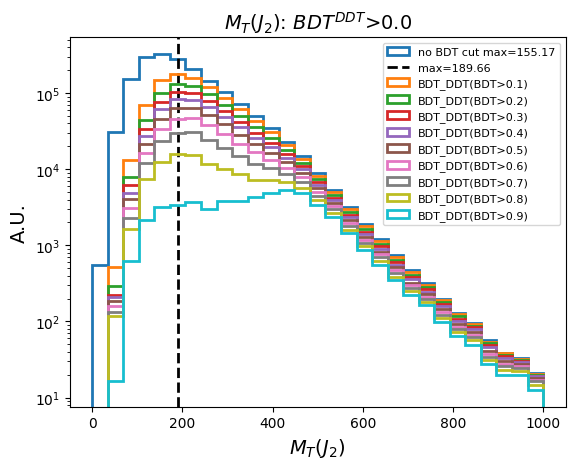

In [7]:
b=np.linspace(0,1000,30)

l1=np.histogram(QCD['mt'], bins=b, weights=QCD_weights)
g=np.where(l1[0]==l1[0].max())[0].tolist(), 
m_l1=l1[1][g]+b[1]/2

l2=np.histogram(QCD['mt'][BKG_score_ddt['QCD'][4]>0], bins=b, weights=QCD_weights[BKG_score_ddt['QCD'][4]>0])
g=np.where(l2[0]==l2[0].max())[0].tolist()
m_l2=l2[1][g]+b[1]/2
    
print(m_l1[0], m_l2[0])
plt.hist(QCD['mt'], bins=b, weights=QCD_weights, histtype='step', linewidth=2, label='no BDT cut max={:.2f}'.format(m_l1[0]))
plt.axvline(x=m_l2[0], linewidth=2, color='black', linestyle='dashed', label='max={:.2f}'.format(m_l2[0]))

for i in range(1,10):    
    plt.hist(QCD['mt'][BKG_score_ddt['QCD'][i]>0], bins=b, weights=QCD_weights[BKG_score_ddt['QCD'][i]>0], histtype='step', linewidth=2, label='BDT_DDT(BDT>{:.1f})'.format(i/10))
    
plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$M_T(J_2)$',fontsize=14)
plt.ylabel('A.U.',fontsize=14)
plt.title('$M_T(J_2)$: $BDT^{DDT}$>0.0',fontsize=14)
plt.savefig('png/ddt/mt_bdtddt_cuts.png')


155.17241379310346


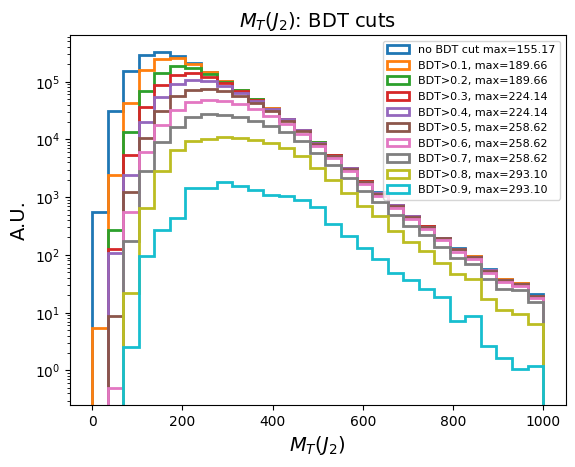

In [8]:
b=np.linspace(0,1000,30)

l1=np.histogram(QCD['mt'], bins=b, weights=QCD_weights)
g=np.where(l1[0]==l1[0].max())[0].tolist(), 
m_l1=l1[1][g]+b[1]/2
print(m_l1[0])
plt.hist(QCD['mt'], bins=b, weights=QCD_weights, histtype='step', linewidth=2, label='no BDT cut max={:.2f}'.format(m_l1[0]))
for i in range(1,10):
    l2=np.histogram(QCD['mt'][QCD_score>i/10], bins=b, weights=QCD_weights[QCD_score>i/10])
    g=np.where(l2[0]==l2[0].max())[0].tolist()
    m_l2=l2[1][g]+b[1]/2
    plt.hist(QCD['mt'][QCD_score>i/10], bins=b, weights=QCD_weights[QCD_score>i/10], histtype='step', linewidth=2, label='BDT>{:.1f}, max={:.2f}'.format(i/10, m_l2[0]))

plt.yscale('log')
plt.legend(fontsize=8)
plt.xlabel('$M_T(J_2)$',fontsize=14)
plt.ylabel('A.U.',fontsize=14)
plt.title('$M_T(J_2)$: BDT cuts',fontsize=14)
plt.savefig('png/ddt/mt_bdtcuts.png')


In [9]:
score_sig_ddt = {}
rhobin_sig = {}
ptbin_sig = {}
score_sig_map_smooth = {} 
RHO_sig_edges = {} 
PT_sig_edges = {}


sig_Hist={}
sig_eff={}

#for s in sig_label_rinv:
for s in sig_score.keys():
    eff=[]
    sig_Hist_tot=np.histogram(sig_score[s],weights=sig_weight[s])
    for i in range(10):
        sig_Hist=[]
        sig_Hist=np.histogram(sig_score[s][sig_score[s]>i/10],weights=sig_weight[s][sig_score[s]>i/10])
        eff.append(sum(sig_Hist[0])/sum(sig_Hist_tot[0]))
    sig_eff[s]=eff
    
    score_sig_ddt[s]        = {}
    rhobin_sig[s]           = {}
    ptbin_sig[s]            = {}
    score_sig_map_smooth[s] = {} 
    RHO_sig_edges[s]        = {} 
    PT_sig_edges[s]         = {}
    for i in range(9):
        score_sig_ddt[s][i+1], rhobin_sig[s][i+1], ptbin_sig[s][i+1], score_sig_map_smooth[s][i+1], RHO_sig_edges[s][i+1], PT_sig_edges[s][i+1] = ddt(signal[s]['mt'], signal[s]['pt'], signal[s]['rho'], sig_score[s], sig_weight[s],sig_eff[s][i]*100)


[bdt:INFO:2023-05-30 19:34:41:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-05-30 19:34:41:common:47 hepcms-in1.umd.edu] Done (took 00m:0.25s)
[bdt:INFO:2023-05-30 19:34:41:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...95.06034868126933
[bdt:INFO:2023-05-30 19:34:41:common:47 hepcms-in1.umd.edu] Done (took 00m:0.41s)
[bdt:INFO:2023-05-30 19:34:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...87.0809119356275
[bdt:INFO:2023-05-30 19:34:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.23s)
[bdt:INFO:2023-05-30 19:34:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...79.22813291610701
[bdt:INFO:2023-05-30 19:34:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.25s)
[bdt:INFO:2023-05-30 19:34:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...71.16674117121018
[bdt:INFO:2023-05-30 19:34:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.26s)
[bdt:INFO:2023-05-30 19:34:42:common:40 hepcms-in1.umd.edu] Cal

[bdt:INFO:2023-05-30 19:34:54:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...76.00366636113571
[bdt:INFO:2023-05-30 19:34:55:common:47 hepcms-in1.umd.edu] Done (took 00m:0.43s)
[bdt:INFO:2023-05-30 19:34:55:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...66.33363886342664
[bdt:INFO:2023-05-30 19:34:55:common:47 hepcms-in1.umd.edu] Done (took 00m:0.39s)
[bdt:INFO:2023-05-30 19:34:55:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...55.34372135655157
[bdt:INFO:2023-05-30 19:34:56:common:47 hepcms-in1.umd.edu] Done (took 00m:0.58s)
[bdt:INFO:2023-05-30 19:34:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...42.59700580506915
[bdt:INFO:2023-05-30 19:34:56:common:47 hepcms-in1.umd.edu] Done (took 00m:0.55s)
[bdt:INFO:2023-05-30 19:34:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...26.141154903756096
[bdt:INFO:2023-05-30 19:34:57:common:47 hepcms-in1.umd.edu] Done (took 00m:0.61s)
[bdt:INFO:2023-05-30 19:34:57:common:40 hepcms-in

[bdt:INFO:2023-05-30 19:35:09:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...18.695563279494017
[bdt:INFO:2023-05-30 19:35:10:common:47 hepcms-in1.umd.edu] Done (took 00m:0.52s)
[bdt:INFO:2023-05-30 19:35:10:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-05-30 19:35:10:common:47 hepcms-in1.umd.edu] Done (took 00m:0.38s)
[bdt:INFO:2023-05-30 19:35:10:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...96.8582289803218
[bdt:INFO:2023-05-30 19:35:10:common:47 hepcms-in1.umd.edu] Done (took 00m:0.23s)
[bdt:INFO:2023-05-30 19:35:10:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...91.84369409660057
[bdt:INFO:2023-05-30 19:35:11:common:47 hepcms-in1.umd.edu] Done (took 00m:0.38s)
[bdt:INFO:2023-05-30 19:35:11:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...86.90742397137653
[bdt:INFO:2023-05-30 19:35:11:common:47 hepcms-in1.umd.edu] Done (took 00m:0.34s)
[bdt:INFO:2023-05-30 19:35:11:common:40 hepcms-in1.umd.edu] Ca

[bdt:INFO:2023-05-30 19:35:25:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...86.81073025335327
[bdt:INFO:2023-05-30 19:35:26:common:47 hepcms-in1.umd.edu] Done (took 00m:0.29s)
[bdt:INFO:2023-05-30 19:35:26:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...81.23861566484524
[bdt:INFO:2023-05-30 19:35:26:common:47 hepcms-in1.umd.edu] Done (took 00m:0.27s)
[bdt:INFO:2023-05-30 19:35:26:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...73.80360986918377
[bdt:INFO:2023-05-30 19:35:26:common:47 hepcms-in1.umd.edu] Done (took 00m:0.27s)
[bdt:INFO:2023-05-30 19:35:26:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...64.00066236131828
[bdt:INFO:2023-05-30 19:35:27:common:47 hepcms-in1.umd.edu] Done (took 00m:0.27s)
[bdt:INFO:2023-05-30 19:35:27:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...52.343103162775506
[bdt:INFO:2023-05-30 19:35:27:common:47 hepcms-in1.umd.edu] Done (took 00m:0.23s)
[bdt:INFO:2023-05-30 19:35:27:common:40 hepcms-in

[bdt:INFO:2023-05-30 19:35:41:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...36.78610480275874
[bdt:INFO:2023-05-30 19:35:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.45s)
[bdt:INFO:2023-05-30 19:35:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...22.335772562873125
[bdt:INFO:2023-05-30 19:35:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.44s)
[bdt:INFO:2023-05-30 19:35:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-05-30 19:35:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.20s)
[bdt:INFO:2023-05-30 19:35:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...97.47155499367913
[bdt:INFO:2023-05-30 19:35:42:common:47 hepcms-in1.umd.edu] Done (took 00m:0.28s)
[bdt:INFO:2023-05-30 19:35:42:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...91.52227262586513
[bdt:INFO:2023-05-30 19:35:43:common:47 hepcms-in1.umd.edu] Done (took 00m:0.26s)
[bdt:INFO:2023-05-30 19:35:43:common:40 hepcms-in1.umd.edu] C

[bdt:INFO:2023-05-30 19:35:56:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...91.67679222357071
[bdt:INFO:2023-05-30 19:35:57:common:47 hepcms-in1.umd.edu] Done (took 00m:0.41s)
[bdt:INFO:2023-05-30 19:35:57:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...85.08707978938635
[bdt:INFO:2023-05-30 19:35:57:common:47 hepcms-in1.umd.edu] Done (took 00m:0.32s)
[bdt:INFO:2023-05-30 19:35:57:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...78.67152693397958
[bdt:INFO:2023-05-30 19:35:57:common:47 hepcms-in1.umd.edu] Done (took 00m:0.38s)
[bdt:INFO:2023-05-30 19:35:57:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...70.53462940461579
[bdt:INFO:2023-05-30 19:35:58:common:47 hepcms-in1.umd.edu] Done (took 00m:0.43s)
[bdt:INFO:2023-05-30 19:35:58:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...61.417577966787086
[bdt:INFO:2023-05-30 19:35:58:common:47 hepcms-in1.umd.edu] Done (took 00m:0.28s)
[bdt:INFO:2023-05-30 19:35:58:common:40 hepcms-in

[bdt:INFO:2023-05-30 19:36:11:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...43.20297004526179
[bdt:INFO:2023-05-30 19:36:12:common:47 hepcms-in1.umd.edu] Done (took 00m:0.27s)
[bdt:INFO:2023-05-30 19:36:12:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...27.895031277016823
[bdt:INFO:2023-05-30 19:36:12:common:47 hepcms-in1.umd.edu] Done (took 00m:0.29s)
[bdt:INFO:2023-05-30 19:36:12:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...13.156690230381562
[bdt:INFO:2023-05-30 19:36:12:common:47 hepcms-in1.umd.edu] Done (took 00m:0.34s)
[bdt:INFO:2023-05-30 19:36:12:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-05-30 19:36:13:common:47 hepcms-in1.umd.edu] Done (took 00m:0.27s)
[bdt:INFO:2023-05-30 19:36:13:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...96.61960957317753
[bdt:INFO:2023-05-30 19:36:13:common:47 hepcms-in1.umd.edu] Done (took 00m:0.31s)
[bdt:INFO:2023-05-30 19:36:13:common:40 hepcms-in1.umd.edu] 

[bdt:INFO:2023-05-30 19:36:28:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...96.64765288947011
[bdt:INFO:2023-05-30 19:36:29:common:47 hepcms-in1.umd.edu] Done (took 00m:0.42s)
[bdt:INFO:2023-05-30 19:36:29:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...90.27492051617581
[bdt:INFO:2023-05-30 19:36:29:common:47 hepcms-in1.umd.edu] Done (took 00m:0.43s)
[bdt:INFO:2023-05-30 19:36:29:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...84.21077239573448
[bdt:INFO:2023-05-30 19:36:30:common:47 hepcms-in1.umd.edu] Done (took 00m:0.49s)
[bdt:INFO:2023-05-30 19:36:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...78.10922012343302
[bdt:INFO:2023-05-30 19:36:30:common:47 hepcms-in1.umd.edu] Done (took 00m:0.50s)
[bdt:INFO:2023-05-30 19:36:30:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...69.3940527398542
[bdt:INFO:2023-05-30 19:36:31:common:47 hepcms-in1.umd.edu] Done (took 00m:0.41s)
[bdt:INFO:2023-05-30 19:36:31:common:40 hepcms-in1.

[bdt:INFO:2023-05-30 19:36:47:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...68.37610313554678
[bdt:INFO:2023-05-30 19:36:47:common:47 hepcms-in1.umd.edu] Done (took 00m:0.47s)
[bdt:INFO:2023-05-30 19:36:47:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...58.38383016796001
[bdt:INFO:2023-05-30 19:36:48:common:47 hepcms-in1.umd.edu] Done (took 00m:0.41s)
[bdt:INFO:2023-05-30 19:36:48:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...45.748098743339696
[bdt:INFO:2023-05-30 19:36:48:common:47 hepcms-in1.umd.edu] Done (took 00m:0.40s)
[bdt:INFO:2023-05-30 19:36:48:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...29.057708731546406
[bdt:INFO:2023-05-30 19:36:49:common:47 hepcms-in1.umd.edu] Done (took 00m:0.54s)
[bdt:INFO:2023-05-30 19:36:49:common:40 hepcms-in1.umd.edu] Calculating ddt scores for ...100.0
[bdt:INFO:2023-05-30 19:36:49:common:47 hepcms-in1.umd.edu] Done (took 00m:0.73s)
[bdt:INFO:2023-05-30 19:36:49:common:40 hepcms-in1.umd.edu] 

In [10]:
def ration(val_sig, val_bkg):
    ratio = val_sig/np.sqrt(val_bkg)
    return ratio



for sc in (4,5,6):
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(10,7))
    fig.subplots_adjust(hspace=0)
    b=np.linspace(QCD['mt'][BKG_score_ddt['QCD'][sc]>0].min(),1000,30)

    BKG = [ZJets['mt'][BKG_score_ddt['ZJets'][sc]>0], WJets['mt'][BKG_score_ddt['WJets'][sc]>0], TTJets['mt'][BKG_score_ddt['TTJets'][sc]>0], QCD['mt'][BKG_score_ddt['QCD'][sc]>0]]
    BKG_Weights = [ZJets_weights[BKG_score_ddt['ZJets'][sc]>0], WJets_weights[BKG_score_ddt['WJets'][sc]>0], TTJets_weights[BKG_score_ddt['TTJets'][sc]>0], QCD_weights[BKG_score_ddt['QCD'][sc]>0]]
                                           

    val_of_bins_x2, edges_of_bins_x2, patches_x2 = a0.hist(BKG, bins=b, weights=BKG_Weights, stacked=True, label=['ZJets', 'WJets', 'TTJets', 'QCD'])
    val_of_bins_x1   = {}
    edges_of_bins_x1 = {}
    ratio            = {}
    bincenter        = {}

    colors=['red', 'blue', 'cyan']
    l=0
    for s in ('BSVJ_250_10_0.3_peak', 'BSVJ_350_10_0.3_peak', 'BSVJ_450_10_0.3_peak'):
        val_of_bins_x1[s], edges_of_bins_x1[s], patches_x1 = a0.hist(signal[s]['mt'][score_sig_ddt[s][sc]>0.0],bins=b, weights=sig_weight[s][score_sig_ddt[s][sc]>0.0], histtype='step',linewidth=2, linestyle='dashed', label=s, color=colors[l])


        ratio[s] = ration(val_of_bins_x1[s], val_of_bins_x2[3])
        bincenter[s] = 0.5 * (edges_of_bins_x1[s][1:] + edges_of_bins_x1[s][:-1])
        a1.plot(bincenter[s], ratio[s], '.', color=colors[l]) 
        l+=1
    a0.legend(fontsize=12)
    a0.set_yscale('log')
    a0.set_title('$M_T(J_2)$ $BDT^{DDT}>0.0, (BDT>0.$'+str(sc)+')', fontsize=15)
    a0.set_ylabel('A.U.', fontsize=15)

    a1.set_xlabel('$M_T(J_2)$', fontsize=15)
    a1.set_ylabel('$S/\sqrt{B}$', fontsize=15)
    a1.grid(True)
    a0.grid(True)
    plt.savefig('png/ddt/mt_sigbkgstacked_bdt0.'+str(sc)+'.png')
    plt.close()
    
    

In [11]:
B={}
S={}
for i in range(10):
    cut = QCD_score > i/10
    B['bdt>0.'+str(i)] = np.histogram(QCD_score[cut], bins=40, weights=QCD_weights[cut])
    S['bdt>0.'+str(i)] = {}
    for j in range(sig_length_rinv):
        cut_sig = sig_score[sig_label_rinv[j]] > i/10
        s = np.histogram(sig_score[sig_label_rinv[j]][cut_sig], bins=40, weights=sig_weight[sig_label_rinv[j]][cut_sig])
        S['bdt>0.'+str(i)][sig_label_rinv[j]] = s
    for j in range(sig_length_mdark):
        cut_sig = sig_score[sig_label_mdark[j]] > i/10
        s = np.histogram(sig_score[sig_label_mdark[j]][cut_sig], bins=40, weights=sig_weight[sig_label_mdark[j]][cut_sig])
        S['bdt>0.'+str(i)][sig_label_mdark[j]] = s

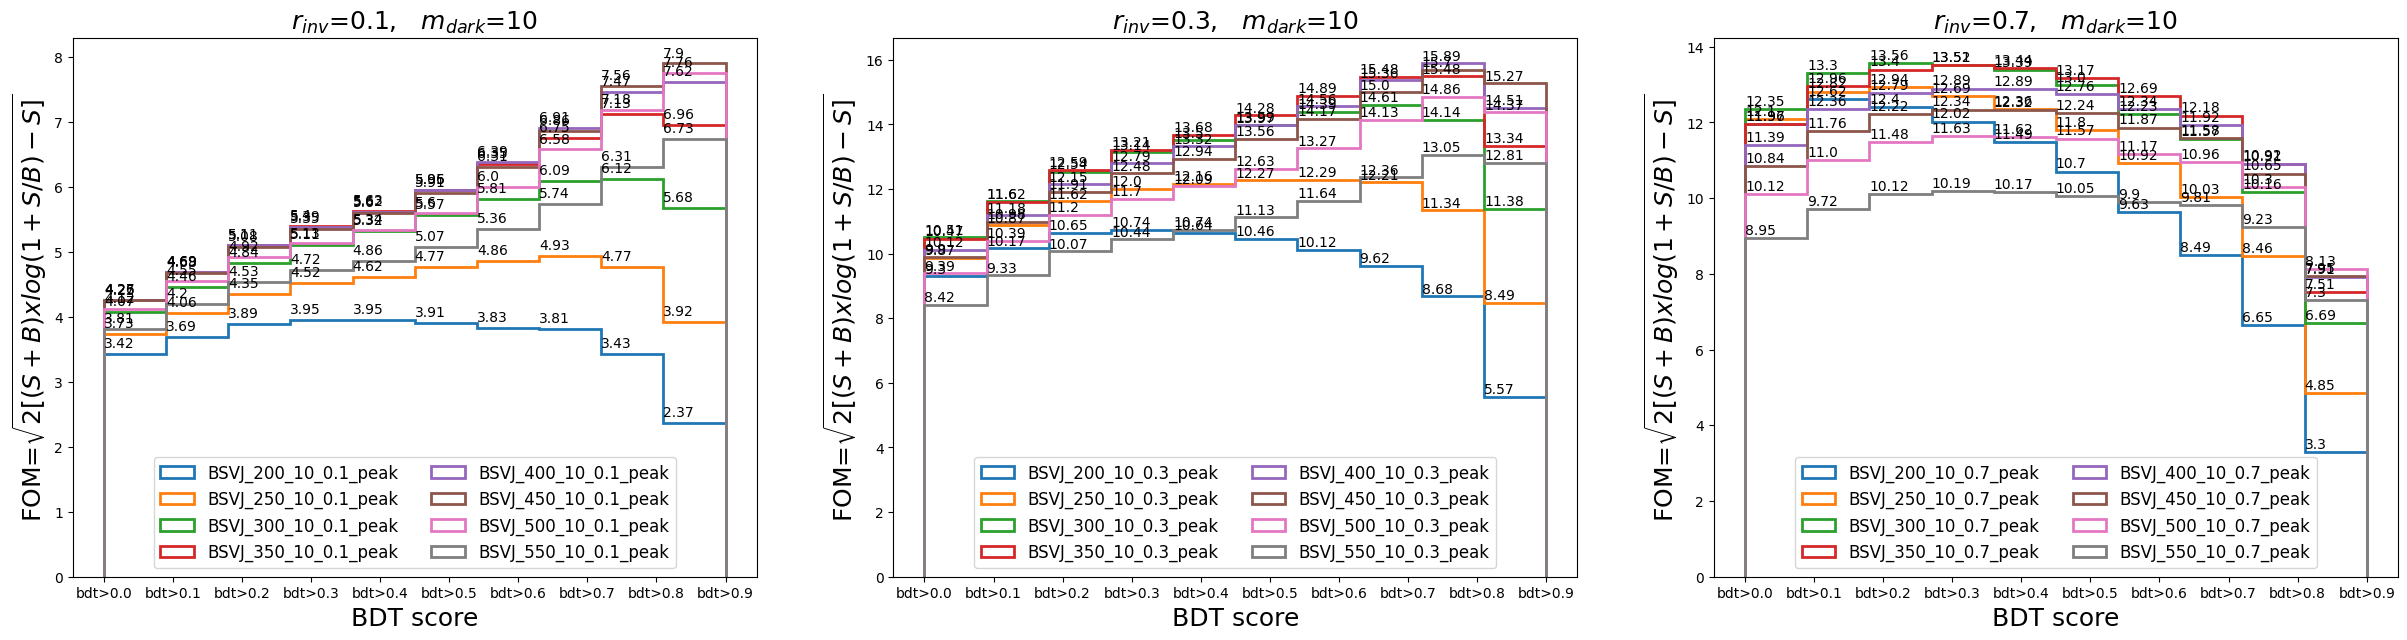

In [12]:
def FOM(s, b):
    FOM = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    return FOM

def addlabels(arr, y_shift, rou):
    for i in range(len(arr[0])):
            plt.text(arr[1][i],arr[0][i]+y_shift,str(round(arr[0][i],rou)))

fom = {}
for i in B.keys():
    fom[i] = {}
    for j in sig_label_rinv:
        fom[i][j] = FOM(sum(S[i][j][0]), sum(B[i][0]))
    for j in sig_label_mdark:
        fom[i][j] = FOM(sum(S[i][j][0]), sum(B[i][0]))
f={}
for j in sig_label_rinv:
    f[j]=[fom[i][j] for i in B.keys()]
    
for j in sig_label_mdark:
    f[j]=[fom[i][j] for i in B.keys()]

g=1
r=1
c=3
fig=plt.figure(figsize=(30,7))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


        
L = ['bdt>0.0', 'bdt>0.1', 'bdt>0.2', 'bdt>0.3', 'bdt>0.4', 'bdt>0.5', 'bdt>0.6', 'bdt>0.7', 'bdt>0.8', 'bdt>0.9']
title = ['$r_{inv}$=0.1', '$r_{inv}$=0.3', '$r_{inv}$=0.7']
d = np.arange(0,1,0.1)
for k in range(3):
    fig.add_subplot(r, c, g)
    for i in range(8):
        arr=plt.hist(L, bins=10, weights=f[sig_label_rinv[3*i+k]], histtype='step', linewidth=2,label=sig_label_rinv[3*i+k])
        addlabels(arr, 0.1, 2)
        plt.xlabel('BDT score',fontsize=18)
        plt.ylabel('FOM=$\sqrt{2[(S+B) x log(1+S/B)-S]}$',fontsize=18)
        plt.legend(loc='lower center', ncol=2,fontsize=12)
    plt.title(title[k]+',   $m_{dark}$=10', fontsize=18)
    g+=1
plt.savefig('png/ddt/fom_rinv.png')

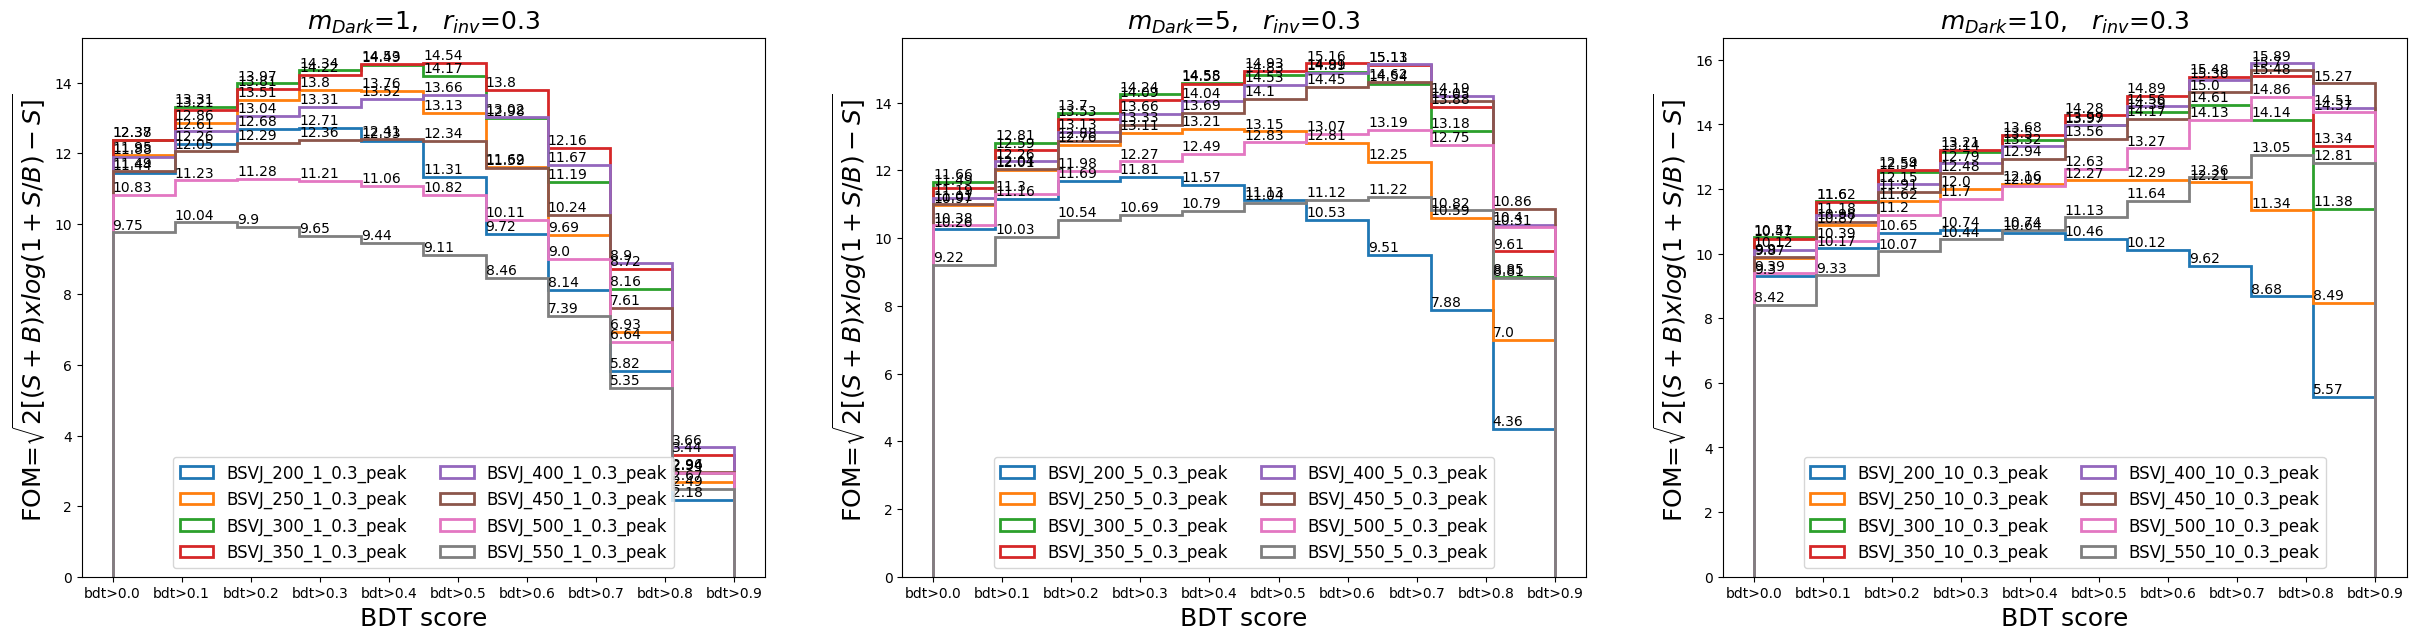

In [13]:
g=1
r=1
c=3
fig=plt.figure(figsize=(30,7))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


        
L = ['bdt>0.0', 'bdt>0.1', 'bdt>0.2', 'bdt>0.3', 'bdt>0.4', 'bdt>0.5', 'bdt>0.6', 'bdt>0.7', 'bdt>0.8', 'bdt>0.9']
title = ['$m_{Dark}$=1', '$m_{Dark}$=5', '$m_{Dark}$=10']
d = np.arange(0,1,0.1)
for k in range(3):
    fig.add_subplot(r, c, g)
    for i in range(8):
        arr=plt.hist(L, bins=10, weights=f[sig_label_mdark[3*i+k]], histtype='step', linewidth=2,label=sig_label_mdark[3*i+k])
        addlabels(arr, 0.1, 2)
        plt.xlabel('BDT score',fontsize=18)
        plt.ylabel('FOM=$\sqrt{2[(S+B) x log(1+S/B)-S]}$',fontsize=18)
        plt.legend(loc='lower center', ncol=2,fontsize=12)
    plt.title(title[k]+',   $r_{inv}$=0.3', fontsize=18)
    g+=1
plt.savefig('png/ddt/fom_mdark.png')

In [14]:
def ROC_curve(data, w, var, var_min, var_max):
    #print(var_min)
    general_cut=(data[var]>var_min)
    
    b=np.linspace(data[var][general_cut].min(), data[var][general_cut].max(),50)
    hist_general=plt.hist(data[var][general_cut], weights=w[general_cut], bins=b)
    tot = sum(hist_general[0])# * (s1[1][1:]-s1[1][:-1]))    
    var_cut = np.linspace(var_min, var_max,30)
    eff=[]
    for i in range(30):
        sr_cut=(data[var]>var_cut[i])
        hist_cut=plt.hist(data[var][sr_cut], weights=w[sr_cut], bins=b)
        single_eff = sum(hist_cut[0])     
        eff.append(single_eff/tot)

    plt.close()
    return eff

qcd_roc={}    
qcd_roc['qcd_score']= QCD_score
qcd_roc['qcd_score_ddt']=[BKG_score_ddt['QCD'][i] for i in range(1,10)]
#qcd_roc['qcd_score_ddt'] = [QCD_score_ddt[i] for i in range(1,10)]
qcd_eff =ROC_curve(qcd_roc, QCD_weights, 'qcd_score', -1, 1)
    
sig_roc_rinv  = {}
sig_roc_mdark  = {}
sig_rinv_eff  = {}
sig_mdark_eff  = {}

lab_sig_rinv = ['BSVJ_'+str(i)+'_10_'+str(j)+'_peak' for i in np.arange(200,510,50) for j in ('0.1','0.3','0.7')]
lab_sig_mdark = ['BSVJ_'+str(i)+'_'+str(j)+'_0.3_peak' for i in np.arange(200,510,50) for j in ('1','5','10')]

for k in range(3):
    for i in range(7):
        sig_roc_rinv[lab_sig_rinv[3*i+k]]  = {}
        sig_roc_rinv[lab_sig_rinv[3*i+k]]['sig_score']   = sig_score[lab_sig_rinv[3*i+k]]
        sig_roc_rinv[lab_sig_rinv[3*i+k]]['score_sig_ddt']   = [score_sig_ddt[lab_sig_rinv[3*i+k]][j] for j in range(1,10)]
        
        sig_roc_mdark[lab_sig_mdark[3*i+k]]  = {}
        sig_roc_mdark[lab_sig_mdark[3*i+k]]['sig_score']   = sig_score[lab_sig_mdark[3*i+k]]
        sig_roc_mdark[lab_sig_mdark[3*i+k]]['score_sig_ddt']   = [score_sig_ddt[lab_sig_mdark[3*i+k]][j] for j in range(1,10)] 
        
    for i in range(7):
        sig_rinv_eff[lab_sig_rinv[3*i+k]] = ROC_curve(sig_roc_rinv[lab_sig_rinv[3*i+k]], sig_weight[lab_sig_rinv[3*i+k]], 'sig_score', -1, 1)
        sig_mdark_eff[lab_sig_mdark[3*i+k]] = ROC_curve(sig_roc_mdark[lab_sig_mdark[3*i+k]], sig_weight[lab_sig_mdark[3*i+k]], 'sig_score', -1, 1)
    

In [25]:
models = {'BDT' : '/home/snabili/data/test/svj_uboost/models/svjbdt_May25_allsignals_qcdttjets.json'}
from collections import OrderedDict
scores = {}
aucs = {}

training_features = [
    'girth', 'ptd', 'axismajor', 'axisminor',
    'ecfm2b1', 'ecfd2b1', 'ecfc2b1', 'ecfn2b2', 'metdphi'
    ]

datadir = '/home/snabili/hadoop/HADD_puweight/'
from svj_ntuple_processing import Columns

qcd_cols = [Columns.load(f) for f in glob.glob(datadir+'/bkg/Summer20UL18/QCD_*.npz')]
#qcd_cols = list(filter(lambda c: c.metadata['ptbin'][0]>=300., qcd_cols))
ttjets_cols = [Columns.load(f) for f in glob.glob(datadir+'/bkg/Summer20UL18/TTJets_*.npz')]
bkg_cols = qcd_cols + ttjets_cols
#signal_cols = [Columns.load(f) for f in glob.glob(datadir+'/signal_notruth/madpt*.npz')]
signal_cols = [Columns.load(f) for f in glob.glob(datadir+'/signal_notruth/madpt300_mz350_mdark10_rinv0.3.npz')]

X, y, weight = columns_to_numpy(signal_cols, bkg_cols, features=training_features, downsample=1.)

# xgboost
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

score=[]
aucurv=[]

for key, model_file in models.items():
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(model_file)
    with time_and_log(f'Calculating xgboost scores for {key}...'):
        score     = xgb_model.predict_proba(X)[:,1]
        aucurv    = roc_auc_score(y, score, sample_weight=weight)

    

all_features = training_features + ['mt', 'rho', 'pt']

    
eff_BKG, eff_SIG, cuts = roc_curve(y, score, sample_weight=weight)

i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][4])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')
i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][5])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')
i_wp = np.argmax(eff_BKG >= bkg_eff['QCD'][6])
print(f'eff_sig: {eff_SIG[i_wp]:.3f}, bkg_eff: {eff_BKG[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

[bdt:INFO:2023-05-30 19:58:45:common:248 hepcms-in1.umd.edu] Downsampling bkg, keeping fraction of 1.0
[bdt:INFO:2023-05-30 19:58:48:common:40 hepcms-in1.umd.edu] Calculating xgboost scores for BDT...
[bdt:INFO:2023-05-30 19:59:35:common:47 hepcms-in1.umd.edu] Done (took 00m:47.51s)


eff_sig: 0.806, bkg_eff: 0.380, cut: 0.402
eff_sig: 0.727, bkg_eff: 0.284, cut: 0.501
eff_sig: 0.631, bkg_eff: 0.197, cut: 0.602


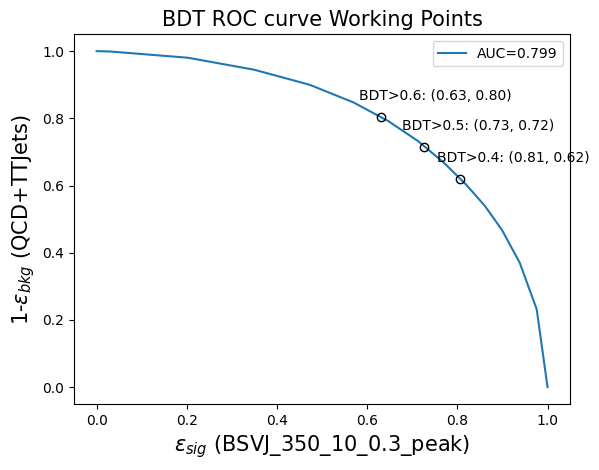

In [26]:
AUC =auc(sig_rinv_eff[lab_sig_rinv[10]], np.ones_like(qcd_eff)-qcd_eff)
plt.plot(sig_rinv_eff[lab_sig_rinv[10]], np.ones_like(qcd_eff)-qcd_eff, label='AUC={:.3f}'.format(AUC))
plt.legend()

x=[]
y=[]
for i in (4,5,6):
    i_wp=np.argmax(eff_BKG >= bkg_eff['QCD'][i])
    x.append(eff_SIG[i_wp])
    y.append(1-eff_BKG[i_wp])

plt.plot(x,y,'o',mfc='none',color='black')

for i in range(3):
    plt.annotate('BDT>0.{:d}: ({:.2f}, {:.2f})'.format(i+4, x[i],y[i]), xy=(x[i], y[i]), xytext=(x[i]-0.05, y[i]+0.05))

plt.xlabel('$\epsilon_{sig}$ ('+lab_sig_rinv[10]+')', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$ (QCD+TTJets)', fontsize=15)
plt.title('BDT ROC curve Working Points', fontsize=15)
plt.savefig('png/ddt/roc_wp.png')

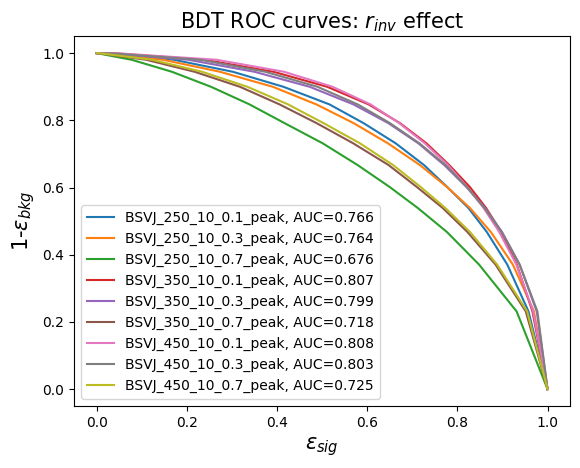

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff)-qcd_eff)
    plt.plot(sig_rinv_eff[lab_sig_rinv[i]], np.ones_like(qcd_eff)-qcd_eff, label=lab_sig_rinv[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('BDT ROC curves: $r_{inv}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_rinveffect.png')

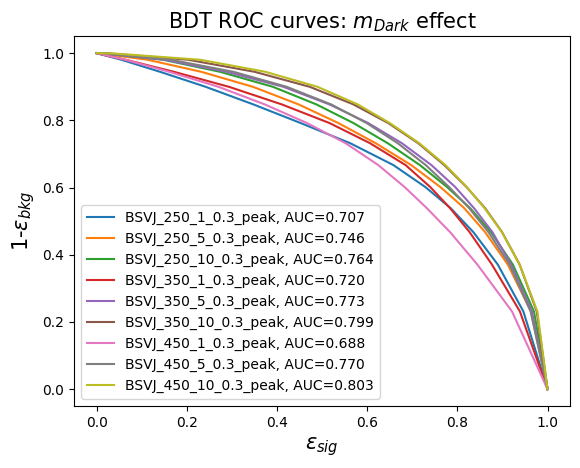

In [28]:
for i in (3,4,5,9,10,11,15,16,17):
    AUC =auc(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff)-qcd_eff)
    plt.plot(sig_mdark_eff[lab_sig_mdark[i]], np.ones_like(qcd_eff)-qcd_eff, label=lab_sig_mdark[i]+', AUC={:.3f}'.format(AUC))
    plt.legend()
plt.xlabel('$\epsilon_{sig}$', fontsize=15)
plt.ylabel('1-$\epsilon_{bkg}$', fontsize=15)
plt.title('BDT ROC curves: $m_{Dark}$ effect', fontsize=15)
plt.savefig('png/ddt/roc_mdarkeffect.png')

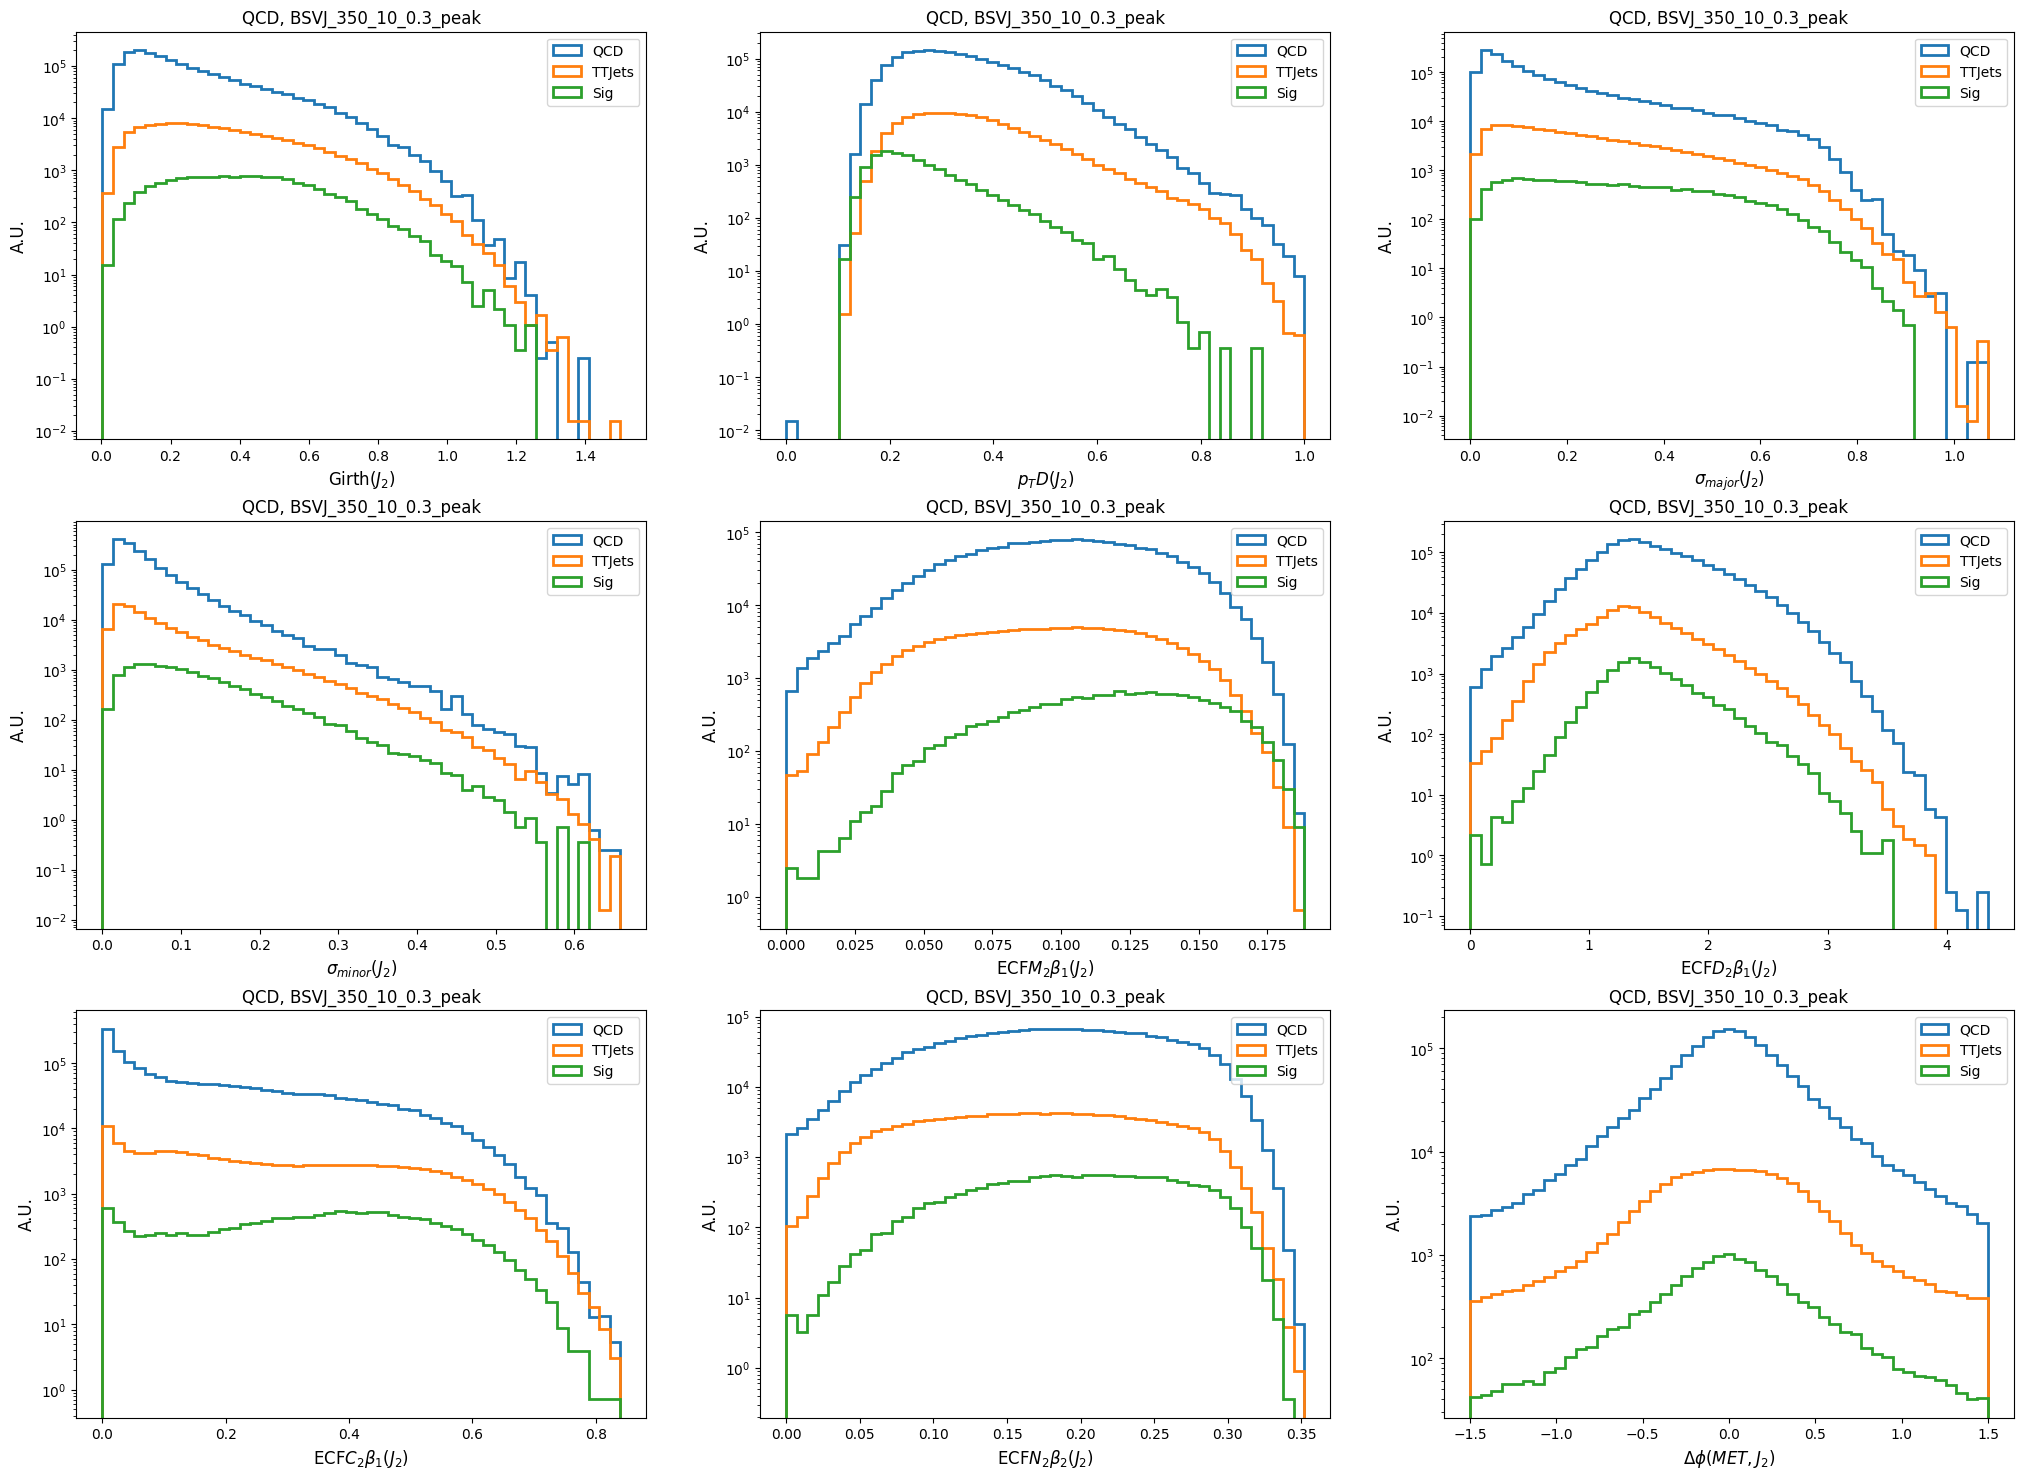

In [29]:
g=1
r=3
c=3
fig=plt.figure(figsize=(25,18))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
bdt_inputvars = ['Girth($J_2$)', '$p_TD(J_2)$', '$\sigma_{major}(J_2)$', '$\sigma_{minor}(J_2)$',r'ECF$M_{2}\beta_1(J_2)$',r'ECF$D_{2}\beta_1(J_2)$',r'ECF$C_{2}\beta_1(J_2)$',r'ECF$N_{2}\beta_2(J_2)$','$\Delta\phi(MET,J_2)$']


d=False
for i in bdt_features:
    fig.add_subplot(r, c, g)
    b=np.linspace(QCD[i].min(), QCD[i].max(),50)
    plt.hist(QCD[i], bins=b, weights=QCD_weights, histtype='step', linewidth=2, label='QCD', density=d)
    plt.hist(TTJets[i], bins=b, weights=TTJets_weights, histtype='step', linewidth=2, label='TTJets', density=d)
    plt.hist(signal[lab_sig_rinv[10]][i], bins=b, weights=sig_weight[lab_sig_rinv[10]], histtype='step', linewidth=2, label='Sig', density=d)
    plt.xlabel(bdt_inputvars[g-1], fontsize=12)
    plt.ylabel('A.U.', fontsize=12)
    plt.title('QCD, '+lab_sig_rinv[10], fontsize=12)
    plt.legend()
    plt.yscale('log')
    g+=1
plt.savefig('png/ddt/bdt_inputvar.png')

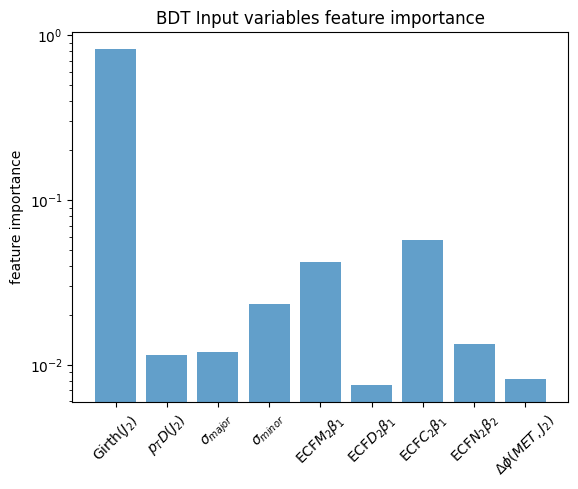

In [30]:
feature_important = xgb_model.feature_importances_
values=[v for i,v in enumerate(feature_important)]

bdt_inputvars = ['Girth($J_2$)', '$p_TD(J_2)$', '$\sigma_{major}$', '$\sigma_{minor}$',r'ECF$M_{2}\beta_1$',r'ECF$D_{2}\beta_1$',r'ECF$C_{2}\beta_1$',r'ECF$N_{2}\beta_2$','$\Delta\phi(MET,J_2)$']
a=plt.bar(bdt_inputvars, values, alpha=0.7)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('BDT Input variables feature importance')
plt.ylabel('feature importance')
plt.savefig('png/ddt/feature_importance.png')
